# Full example

We'll target the following dates:

In [14]:
%reset

In [1]:
# Packages needed
import numpy as np
import matplotlib.pyplot as plt

import astropy
from sunpy.coordinates import get_body_heliographic_stonyhurst
from sunpy.coordinates import frames
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

from skyfield.api import load
from astropy.time import Time

import astroquery.heasarc
from astroquery.heasarc import Heasarc, Conf

import functions

First get venus positions and times

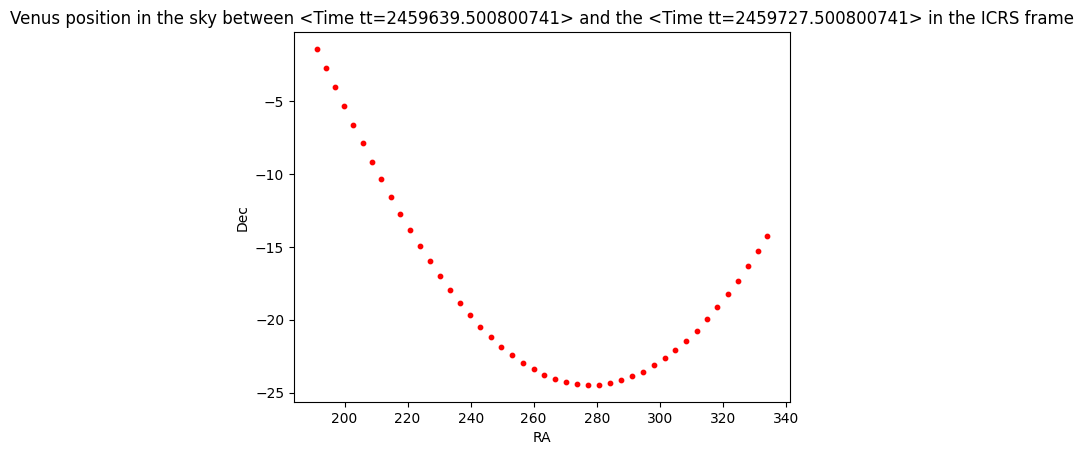

In [25]:
venus_times,venus_positions = functions.get_venus_position(2022,3,1,90,2)
functions.plot_venus_position(venus_times,venus_positions)

Then get the scw list in the time range.

In [32]:
radius = '5 degree'
for coord,time in zip(venus_positions,venus_times):
    delta_time = time + 1
    time = time.utc_strftime('%Y-%m-%dT%H:%M:%S')
    delta_time = delta_time.utc_strftime('%Y-%m-%dT%H:%M:%S')
    table = functions.get_scw_list(coord,radius,time,delta_time)
    if not table:
        continue
    else:
        table.write('scw/'+str(time.replace(':','_')) + '.fits',overwrite=True)

Check the results in the directory and find a suitable one.

In [33]:
test = astropy.table.Table.read('scw/2022-04-24T00_00_00.fits')
print(test['RA_X'],'\n',test['DEC_X'],'\n',test['SEARCH_OFFSET_'][0])

      RA_X      
----------------
276.233825683594
278.533782958984
275.608367919922
277.880828857422
275.025085449219
277.245208740234 
       DEC_X      
-----------------
-24.4952220916748
-23.9114170074463
-22.3942222595215
-21.8249168395996
-20.2925548553467
-19.7344722747803 
  59.711 (277.3267328487562,-24.463069933761048)



In [35]:
for i in range(6):
    print(str(test['SCW_ID'][i])+'.'+str(test['SCW_VER'][i]))

249500260010.001
249500250010.001
249500270010.001
249500240010.001
249500280010.001
249500230010.001


Now let's do a query for a jemx image.

In [18]:
#Get some login

import getpass
token = getpass.getpass('insert your token: ')
import oda_api.token
oda_api.token.decode_oda_token(token)


{'sub': 'kent.barbey@epfl.ch',
 'email': 'kent.barbey@epfl.ch',
 'name': 'kbarbey',
 'roles': 'authenticated user, integral-private-qla',
 'exp': 1682004338}

In [19]:
import logging
logging.getLogger().setLevel(logging.INFO)
logging.getLogger('oda_api').addHandler(logging.StreamHandler())

In [36]:
scw_pick_test = ['249500260010.001',
'249500250010.001',
'249500270010.001',
'249500240010.001',
'249500280010.001',
'249500230010.001']

from oda_api.api import DispatcherAPI

disp = DispatcherAPI(url="https://www.astro.unige.ch/mmoda/dispatch-data", instrument="mock")

par_dict = {
"E1_keV": "3",
"E2_keV": "10",
"detection_threshold": "5",
"instrument": "jemx",
"osa_version": "OSA11.2",
"product": "jemx_image",
"product_type": "Real",
"scw_list": scw_pick_test,
"integral_data_rights": "all-private",#all-private or public
"token": token
}

data_collection = disp.get_product(**par_dict)

please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
please beware that by default, in a typical setup, oda_api will not output much. To learn how to increase the verbosity, please refer to the documentation: https://oda-api.readthedocs.io/en/latest/user_guide/ScienceWindowList.html?highlight=logging#Let's-get-some-logging . 
To disable this message you can pass `.get_product(..., silent=True)`
- waiting for remote response (since 2023-04-16 18:34:48), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
- waiting for remote response (since 2023-04-16 18:34:48), please wait for https://www.astro.unige.ch/mmoda/dispatch-data/run_analysis
session: HUU17GQPONKU9BB1 job: ee8af4109

Now we try to plot it.

In [57]:
print(type(data_collection._p_list[0]))

<class 'oda_api.data_products.NumpyDataProduct'>


In [58]:
from oda_api.plot_tools import OdaImage,OdaLightCurve
from oda_api.data_products import BinaryData
import os 
data_collection.dispatcher_catalog_1.table
# Plot of the data with sources detected.
im = OdaImage(data_collection._p_list[0])
im.show(sliders=False)

No instrument in data collection
No instrument in data collection


AttributeError: 'NumpyDataProduct' object has no attribute 'mosaic_image_0_mosaic'